In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest
import seaborn as sns
import time
%matplotlib inline

we will be using Churn modelling dataset for comparing two models.

In [2]:
df = pd.read_csv('~/Downloads/Churn_Modelling.csv')

IsActiveMember column has both the values set up equally in dataset, so we'll be using it as label.

/home/vivek/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


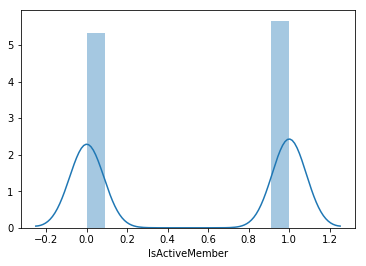

In [3]:
sns.distplot(df['IsActiveMember'])

## Data Preprocessing

In [4]:
df = df.drop(['RowNumber', 'Surname'], 1)

In [5]:
df['Gender'] = df['Gender'].replace('Male', 1)
df['Gender'] = df['Gender'].replace('Female', 0)

In [6]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [7]:
df['France'] = df['Geography'] == 'France'
df['Germany'] = df['Geography'] == 'Germany'
df['Spain'] = df['Geography'] == 'Spain'

In [8]:
df['France'] = df['France'].replace(True, 1)
df['Germany'] = df['Germany'].replace(True, 1)
df['Spain'] = df['Spain'].replace(True, 1)

## PCA

In [9]:
pca = PCA(.95)
df = df.drop('Geography',1)
X = df.drop('IsActiveMember', 1)
Y = df['IsActiveMember']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 55)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
df_train_pca = pca.transform(X_train)
df_test_pca = pca.transform(X_test)
print(df_train_pca.shape)
print(df_test_pca.shape)

(7500, 3)
(2500, 3)


Here, we used PCA with 95% of variance and it reduced feature size from 13 to 3. It means 3 features contains 95% knowledge of 13 features.

## SelectKBest

In [11]:
X_new_test = SelectKBest(k=10).fit_transform(X_test, Y_test)

In [12]:
X_new = SelectKBest(k=10).fit_transform(X_train, Y_train)

In [13]:
X_new

array([[521.,   0.,  39., ...,   1.,   0.,   0.],
       [630.,   0.,  26., ...,   1.,   0.,   0.],
       [555.,   1.,  42., ...,   0.,   1.,   0.],
       ...,
       [668.,   1.,  72., ...,   1.,   0.,   0.],
       [544.,   1.,  37., ...,   1.,   0.,   0.],
       [756.,   1.,  34., ...,   1.,   0.,   0.]])

## Decision Tree

In [14]:
decision_tree = tree.DecisionTreeClassifier(criterion='entropy')

In [15]:
start = time.time()
decision_tree.fit(X_new, Y_train)
Y_pred = decision_tree.predict(X_new)
print("--- %s seconds ---" % (time.time() - start))
print("Classification report: ")
print(classification_report(Y_train, Y_pred))
print("Cross Validation: ")
print(cross_val_score(decision_tree, df_train_pca, Y_train, cv=10))
print("Confusion Matrix: ")
print(confusion_matrix(Y_train, Y_pred))

--- 0.1862637996673584 seconds ---
Classification report: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3614
          1       1.00      1.00      1.00      3886

avg / total       1.00      1.00      1.00      7500

Cross Validation: 
[0.5286285  0.47669774 0.50732357 0.49001332 0.49733333 0.51066667
 0.52736983 0.52336449 0.49799733 0.51668892]
Confusion Matrix: 
[[3614    0]
 [   0 3886]]


In [16]:
Y_test_pred = decision_tree.predict(X_new_test)

#print confusion matrix for test set
print(confusion_matrix(Y_test, Y_test_pred))
print("test data score: ", decision_tree.score(X_new_test, Y_test))

[[ 168 1067]
 [ 208 1057]]
test data score:  0.49


## Random Forest with PCA

In [17]:
start = time.time()
rfc = ensemble.RandomForestClassifier(n_estimators=1)

# params for GridSearchCV
param_grid = {
    'n_estimators': [20, 30, 40, 50, 60],
    'max_features': ['auto', 'sqrt', 'log2']
}

# using GridSearchCV to select best suited params
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(df_train_pca, Y_train)
Y_pred = CV_rfc.predict(df_train_pca)

#printing best parameters
print(CV_rfc.best_params_)

#printing time taken to complete iteration
print("--- %s seconds ---" % (time.time() - start))
print("Classification report: ")
print(classification_report(Y_train, Y_pred))
print("Cross Validation: ")
print(cross_val_score(rfc, df_train_pca, Y_train, cv=10))
print("Confusion Matrix: ")
print(confusion_matrix(Y_train, Y_pred))

{'max_features': 'log2', 'n_estimators': 40}
--- 67.3730685710907 seconds ---
Classification report: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3614
          1       1.00      1.00      1.00      3886

avg / total       1.00      1.00      1.00      7500

Cross Validation: 
[0.50998668 0.50466045 0.49001332 0.49533955 0.516      0.48133333
 0.5046729  0.50066756 0.51535381 0.4953271 ]
Confusion Matrix: 
[[3613    1]
 [   2 3884]]


In [18]:
Y_test_pred = CV_rfc.predict(df_test_pca)
print(confusion_matrix(Y_test, Y_test_pred))

print("test data score: ", CV_rfc.score(df_test_pca, Y_test))

[[616 619]
 [656 609]]
test data score:  0.49


## Random Forest with SelectKBest

In [19]:
start = time.time()
rfc = ensemble.RandomForestClassifier(n_estimators=1)

# params for GridSearchCV
param_grid = {
    'n_estimators': [20, 30, 40, 50, 60],
    'max_features': ['auto', 'sqrt', 'log2']
}

# using GridSearchCV to select best suited params
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_new, Y_train)
Y_pred = CV_rfc.predict(X_new)

#printing best parameters
print(CV_rfc.best_params_)

#printing time taken to complete iteration
print("--- %s seconds ---" % (time.time() - start))
print("Classification report: ")
print(classification_report(Y_train, Y_pred))
print("Cross Validation: ")
print(cross_val_score(rfc, X_new, Y_train, cv=10))
print("Confusion Matrix: ")
print(confusion_matrix(Y_train, Y_pred))

{'max_features': 'auto', 'n_estimators': 30}
--- 66.44174551963806 seconds ---
Classification report: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3614
          1       1.00      1.00      1.00      3886

avg / total       1.00      1.00      1.00      7500

Cross Validation: 
[0.53661784 0.51664447 0.51797603 0.563249   0.52133333 0.56666667
 0.55006676 0.53805073 0.52202937 0.56875834]
Confusion Matrix: 
[[3614    0]
 [   0 3886]]


In [21]:
Y_test_pred = CV_rfc.predict(X_new_test)
print(confusion_matrix(Y_test, Y_test_pred))

print("test data score: ", CV_rfc.score(X_new_test, Y_test))

[[1128  107]
 [1163  102]]
test data score:  0.492


Decision tree and Random Forest worked similarly on test score. And PCA and SelectKBest models also worked similarly here.

More number of estimators makes the random forest model more accurate than decision tree. But it might also cause overfitting.

In conclusion we can say that random forest is faster than decision tree and it is more accurate.